In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy.stats as st
from scipy.integrate import odeint, simps
from scipy.optimize import curve_fit
from tqdm import tqdm
from random import choices
import json


Bad key text.latex.preview in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default qualit

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [232]:
def rungekutta4(f, y0, t, args=()):
    originals = []
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n - 1):
        if t[i] % 10 == 0 and list(args)[2] < 300 and 0 < t[i] < 3000:
            args = (list(args)[0], list(args)[1], list(args)[2]+1)
            # print(list(args)[2])
            originals.append(f(y[i], t[i], *args)[1])
        h = t[i+1] - t[i]
        # print(list(args)[-1])
        k1 = f(y[i], t[i], *args)[0]
        k2 = f(y[i] + k1 * h / 2., t[i] + h / 2., *args)[0]
        k3 = f(y[i] + k2 * h / 2., t[i] + h / 2., *args)[0]
        k4 = f(y[i] + k3 * h, t[i] + h, *args)[0]
        y[i+1] = y[i] + (h / 6.) * (k1 + 2*k2 + 2*k3 + k4)
    return y, originals

In [233]:
def generalized_LV_mutation(x, t, r, A, i):
    father = np.nan
    if t % 10 == 0 and 300 > i:
        props = x
        weigths = x[np.where(x > 0)[0]]/np.sum(x[np.where(x > 0)[0]])
        populations = np.where(x > 0)[0]
        father = choices(populations, weigths, k = 1)[0]
        # print(father)
        # print(i,t)
        x[i] = 0.001
        # print(np.argmax(x))
        # print(A[:,0])
        # print(np.random.normal(0, A[np.argmax(x)]/20, len(A[i])))
        A[i] = A[father] + np.random.normal(0, 0.05, len(A[father]))
        r[i] = r[father] + np.random.normal(0, 0.05)
        if r[i] < 0:
            r[i] = 0.05
        A[i][np.where(A[i] > 0)[0]] = -0.001
        A[i,i] = -1
        # print(r[np.argmax(x)], r[i], i)
    x[np.where(x < 1e-5)[0]] = 0
    return r * x * (1 + A.dot(x)), [father, i]

In [234]:
# number of equations
n = 300
r = np.zeros(n)
A = np.zeros((n, n))

x0 = np.zeros(n)

In [235]:
x0[0] = 0.001

In [236]:
A[0] += -1 + np.random.normal(0, 0.3, n)
r[0] += 0.2

In [237]:
t = np.arange(0, 3500.1, 0.1)

idx = 0
sol, fathers = rungekutta4(generalized_LV_mutation, x0, t, args=(r,A,idx))

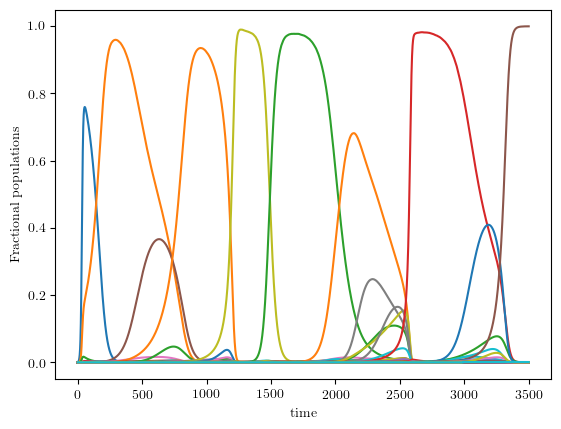

In [238]:
# plt.plot(t, sol[:,0]/np.sum(sol, axis = 1))
# plt.plot(t, sol[:,1]/np.sum(sol, axis = 1))
# plt.plot(t, sol[:,2]/np.sum(sol, axis = 1))
# plt.fill_between(t, 0, 1)
# plt.fill_between(t, 0, sol[:,0]/np.sum(sol, axis = 1))
# plt.fill_between(t, sol[:,0]/np.sum(sol, axis = 1) + sol[:,1]/np.sum(sol, axis = 1), 1)
# plt.fill_between(t, sol[:,0]/np.sum(sol, axis = 1) + sol[:,1]/np.sum(sol, axis = 1) + sol[:,2]/np.sum(sol, axis = 1), 1)
plt.plot(t, sol)
# plt.ylim(0, 1.05)
plt.xlabel('time')
plt.ylabel('Fractional populations')
plt.show()

In [239]:
non_zero_list = list(set(np.where(sol > 0.01)[1]))
#non_zero_list.reverse()

In [240]:
dominant_list = list(set(np.where(sol >= 0.4)[1]))
dominant_list.sort()

In [241]:
non_zero_list.sort()

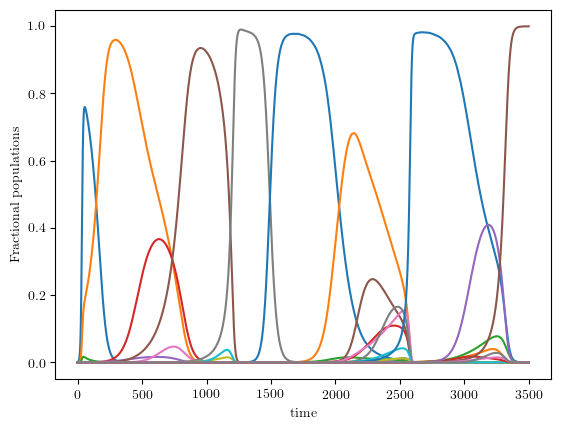

In [242]:
plt.plot(t, sol[:,non_zero_list])
# plt.plot(t, sol[:,193])
# plt.plot(t, sol[:,4])
# plt.ylim(0, 1.05)
plt.xlabel('time')
plt.ylabel('Fractional populations')
plt.show()

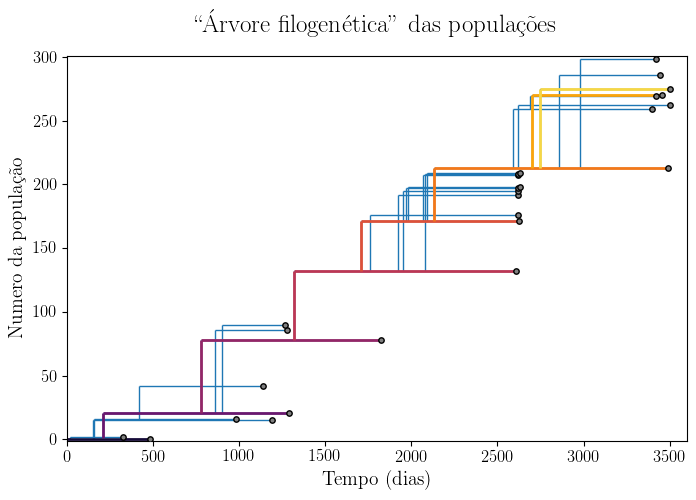

In [260]:
fathers = np.array(fathers)

fig, ax = plt.subplots(figsize = (8,5))
for i in range(n-1):
    if i == 0:
        if 0 in dominant_list:
            plt.hlines(0, np.where(sol[:,i] > 0)[0][0]*0.1, np.where(sol[:,i] > 0)[0][-1]*0.1,
                       lw = 2,
                      color = sns.color_palette('inferno', len(dominant_list))[0])
            plt.scatter(np.where(sol[:,i] > 0)[0][-1]*0.1, 0, edgecolor = 'black',
                       facecolor = 'grey', zorder = 5, s = 15)
        else:
            plt.hlines(0, np.where(sol[:,i] > 0)[0][0]*0.1, np.where(sol[:,i] > 0)[0][-1]*0.1,
                  lw = 1)
    else:
        if fathers[i,1] in non_zero_list:
            plt.hlines(fathers[i,1], np.where(sol[:,i+1] > 0)[0][0]*0.1,
                       np.where(sol[:,i+1] > 0)[0][-1]*0.1, lw = 1)
            plt.vlines(np.where(sol[:,i+1] > 0)[0][0]*0.1, fathers[i,1], fathers[i,0], lw = 1,
                      zorder = 0)
            plt.scatter(np.where(sol[:,i+1] > 0)[0][-1]*0.1, fathers[i,1], edgecolor = 'black',
                       facecolor = 'grey', zorder = 5, s = 15)
        if fathers[i,1] in dominant_list:
            plt.hlines(fathers[i,1], np.where(sol[:,i+1] > 0)[0][0]*0.1,
                       np.where(sol[:,i+1] > 0)[0][-1]*0.1, lw = 2,
                      color = sns.color_palette('inferno',
                                                len(dominant_list))[np.where(dominant_list == fathers[i,1])[0][0]])
            plt.vlines(np.where(sol[:,i+1] > 0)[0][0]*0.1, fathers[i,1], fathers[i,0], lw = 2,
                      color = sns.color_palette('inferno',
                                                len(dominant_list))[np.where(dominant_list == fathers[i,1])[0][0]])
    
# plt.xscale('log')
# plt.xlim(1e1, 4e3)
plt.ylim(-1, 301)
plt.xlim(0, 3600)
plt.xticks(fontsize = 12)
plt.xlabel('Tempo (dias)', fontsize = 14)
plt.yticks(fontsize = 12)
plt.ylabel('Numero da população', fontsize = 14)
plt.title('``Árvore filogenética" das populações', fontsize = 18, pad = 16)
plt.savefig('Plots/ancestral_tree_2.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [247]:
existence_time = []

for i in range(150):
    if i not in non_zero_list:
        ti = np.where(sol[:,i] > 0)[0][0]*0.1
        tf = np.where(sol[:,i] > 0)[0][-1]*0.1
        existence_time.append(tf - ti)

existence_time_relev = []

for i in non_zero_list:
    if i not in dominant_list:
        ti = np.where(sol[:,i] > 0)[0][0]*0.1
        tf = np.where(sol[:,i] > 0)[0][-1]*0.1
        existence_time_relev.append(tf - ti)
    
existence_time_dom = []

for i in dominant_list[:-1]:
    ti = np.where(sol[:,i] > 0)[0][0]*0.1
    tf = np.where(sol[:,i] > 0)[0][-1]*0.1
    existence_time_dom.append(tf - ti)

In [248]:
print(f'Tempo de existência para populações: {np.mean(existence_time):.1f} +/- {np.std(existence_time):.1f}')
print(f'Tempo de existência para populações relevantes: {np.mean(existence_time_relev):.1f} +/- {np.std(existence_time_relev):.1f}')
print(f'Tempo de existência para populações dominantes: {np.mean(existence_time_dom):.1f} +/- {np.std(existence_time_dom):.1f}')

Tempo de existência para populações: 393.7 +/- 241.2
Tempo de existência para populações relevantes: 645.3 +/- 185.6
Tempo de existência para populações dominantes: 999.9 +/- 264.7


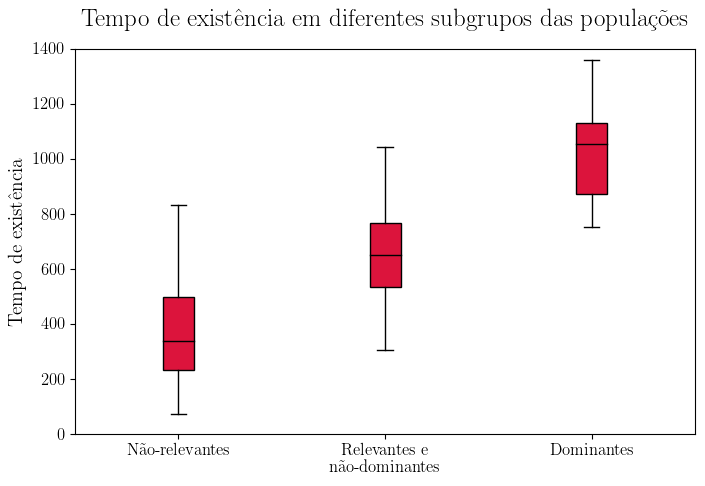

In [261]:
fig, ax = plt.subplots(figsize = (8,5))
box1 = plt.boxplot(existence_time, patch_artist=True, positions = [0],
                   medianprops = {'color': 'black'}, showfliers = False)
box2 = plt.boxplot(existence_time_relev, patch_artist=True, positions = [1],
                  medianprops = {'color': 'black'}, showfliers = False)
box3 = plt.boxplot(existence_time_dom, patch_artist=True, positions = [2],
                  medianprops = {'color': 'black'}, showfliers = False)

colors = ['crimson']
for bplot in (box1, box2, box3):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
plt.ylim(0, 1400)
plt.xticks([0,1,2], labels = ['Não-relevantes', 'Relevantes e \n não-dominantes', 'Dominantes'], fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('Tempo de existência', fontsize = 14)
plt.title('Tempo de existência em diferentes subgrupos das populações', fontsize = 18, pad = 16)
plt.savefig('Plots/existence_time_2.png', dpi = 300, bbox_inches = 'tight')
plt.show()

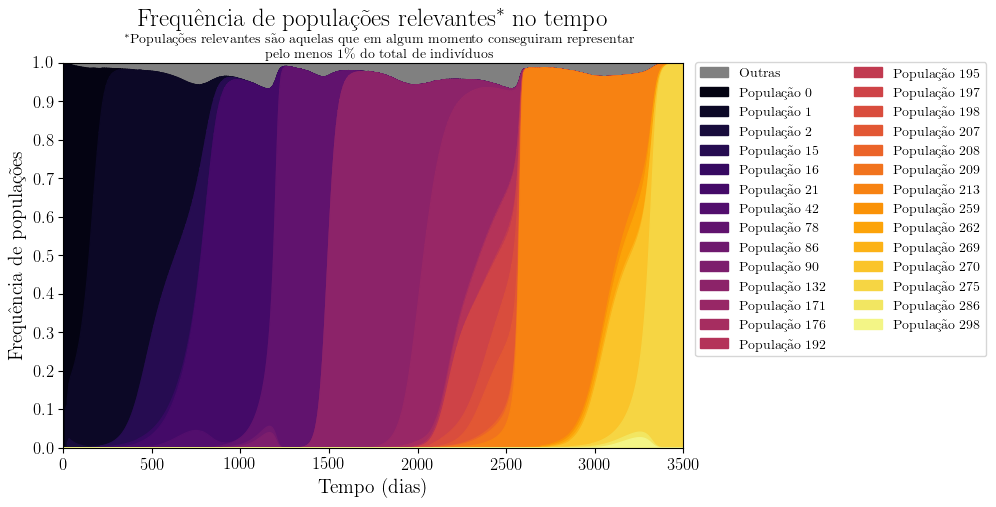

In [262]:
fig, ax = plt.subplots(figsize = (8,5))
cmap = 'inferno'

plt.fill_between(t, 0, 1, color = 'grey', label = 'Outras')
for idx, key in enumerate(non_zero_list):
# for idx, key in enumerate(provisory_list):
    plt.fill_between(t, 0, np.sum(sol[:,non_zero_list[idx:]], axis = 1)/np.sum(sol, axis = 1),
                     color = sns.color_palette(cmap, len(non_zero_list))[idx],
                    label = f'População {key}')

plt.xlabel('Tempo (dias)', fontsize = 14)
plt.ylabel('Frequência de populações', fontsize = 14)
plt.xlim(0, t[-1])
plt.ylim(0, 1)
# plt.xticks([])
# plt.yticks([])
plt.xticks(fontsize = 12)
plt.yticks([0.1*i for i in range(11)], fontsize = 12)
plt.legend(bbox_to_anchor = (1.5,1.02), ncol = 2)
plt.title(r'Frequência de populações relevantes$^*$ no tempo', fontsize = 18, pad = 26)
fig.text(0.52, 0.89, r'$^*$Populações relevantes são aquelas que em algum momento conseguiram representar'
         '\n'
         r'pelo menos 1\% do total de indivíduos',
         ha = 'center', fontsize = 10)
plt.savefig(f'Plots/Competitive_exclusion_frequency_plot_{cmap}_v3_pt-br_2.png',
            dpi = 300, bbox_inches = 'tight')
plt.savefig(f'Plots/Competitive_exclusion_frequency_plot_{cmap}_v3_pt-br_2.svg',
            dpi = 300, bbox_inches = 'tight')
plt.show()

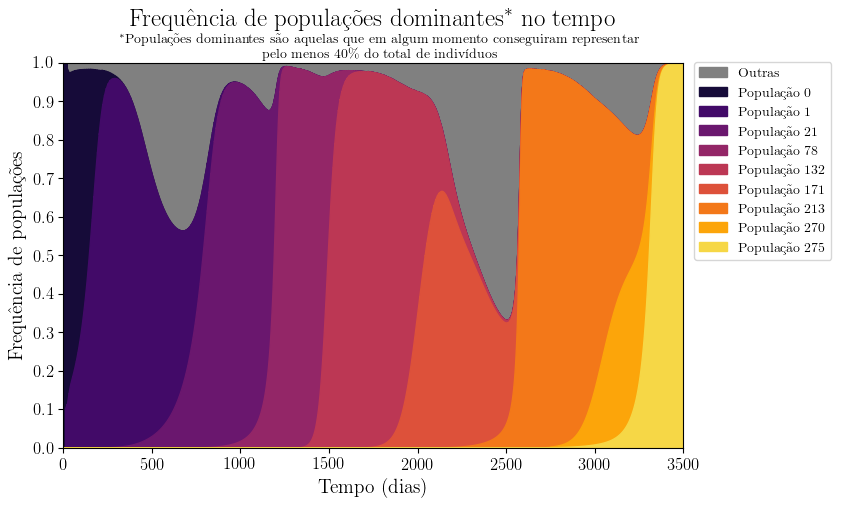

In [263]:
fig, ax = plt.subplots(figsize = (8,5))
cmap = 'inferno'

plt.fill_between(t, 0, 1, color = 'grey', label = 'Outras')
dom_idx = 0
for idx, key in enumerate(dominant_list):
# for idx, key in enumerate(provisory_list):
    plt.fill_between(t, 0, np.sum(sol[:,dominant_list[idx:]], axis = 1)/np.sum(sol, axis = 1),
                     color = sns.color_palette(cmap, len(dominant_list))[idx],
                    label = f'População {key}')

plt.xlabel('Tempo (dias)', fontsize = 14)
plt.ylabel('Frequência de populações', fontsize = 14)
plt.xlim(0, t[-1])
plt.ylim(0, 1)
# plt.xticks([])
# plt.yticks([])
plt.xticks(fontsize = 12)
plt.yticks([0.1*i for i in range(11)], fontsize = 12)
plt.legend(bbox_to_anchor = (1.25,1.02))
plt.title(r'Frequência de populações dominantes$^*$ no tempo', fontsize = 18, pad = 26)
fig.text(0.52, 0.89, r'$^*$Populações dominantes são aquelas que em algum momento conseguiram representar'
         '\n'
         r'pelo menos 40\% do total de indivíduos',
         ha = 'center', fontsize = 10)
plt.savefig(f'Plots/Competitive_exclusion_frequency_plot_dominant_{cmap}_v3_pt-br_2.png',
            dpi = 300, bbox_inches = 'tight')
plt.savefig(f'Plots/Competitive_exclusion_frequency_plot_dominant_{cmap}_v3_pt-br_2.svg',
            dpi = 300, bbox_inches = 'tight')
plt.show()

\begin{align}
    \mathrm{f}_i = r_i + \frac{1}{n_i} \sum_{j = 1}^{n_i} A_{ij}
\end{align}

\begin{align}
    \mathrm{f}_i = r_i + \sum_{j = 1}^{n_i} A_{ij} \int_{t_i}^{t_f} x_j(t) \, \mathrm{d}t
\end{align}

---
$$ A_{01} \int_{t_i}^{t_f} x_0(t) x_1(t) \, \mathrm{d}t $$
$$ \triangledown $$

In [744]:
tf = np.where(sol[:,dominant_list[0]] > 0)[0][-1]
ti = np.where(sol[:,dominant_list[0]] > 0)[0][0]

print(A[0,dominant_list[1]]*simps(sol[ti:tf,dominant_list[1]], t[ti:tf])*simps(sol[ti:tf,0], t[ti:tf]))

-52050.245090582655


In [593]:
simps(sol[:,dominant_list[1]], t)/(t[np.where(sol[:,dominant_list[1]] > 0)[0][-1]] - t[np.where(sol[:,dominant_list[1]] > 0)[0][0]])

0.1535403051562006

In [566]:
A[0,dominant_list[1]]

-1.0164784794056918

In [774]:
# fit_r = []
# fit_a = []
fit_total = []

for i in dominant_list:
    # ratios_r = []
    # ratios_a = []
    # ratios_sum = []
    fit = r[i]
    tf = np.where(sol[:,i] > 0)[0][-1]
    ti = np.where(sol[:,i] > 0)[0][0]
    n_populations = list(set(np.where(sol[np.where(sol[:,i] > 0)[0][0]:np.where(sol[:,i] > 0)[0][-1],:] > 0)[1]))
    for j in n_populations:
        if j != i:
            # r_ratio = r[i]/r[j]
            # a_ratio = np.sum(A[i,n_populations])/np.sum(A[j,n_populations])
            # ratios_r.append(r_ratio)
            # ratios_a.append(a_ratio)
            # ratios_sum.append(r_ratio + a_ratio)
            fit += A[i,j]*simps(sol[ti:tf,j], t[ti:tf])/(t[tf] - t[ti])
    # fit_r.append(ratios_r)
    # fit_a.append(ratios_a)
    fit_total.append(r[i] + r[i]*fit)
    #fitness.append(r[i] + np.sum(A[i,np.array(list(set(np.where(sol[:np.where(sol[:,i] > 0)[0][-1],:] > 0)[1])))])/n_populations)

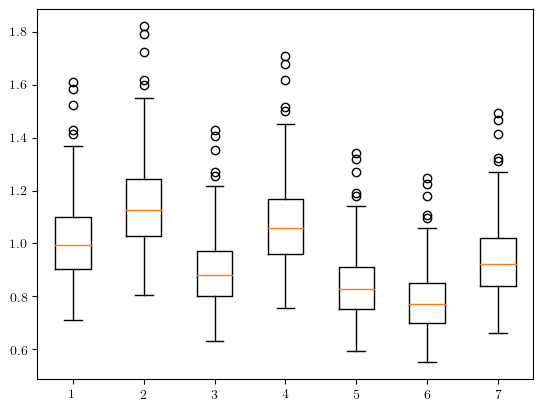

In [623]:
plt.boxplot(fit_r)
plt.show()

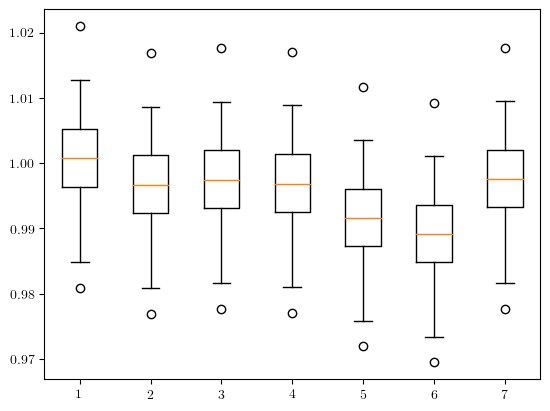

In [583]:
plt.boxplot(fit_a)
plt.show()

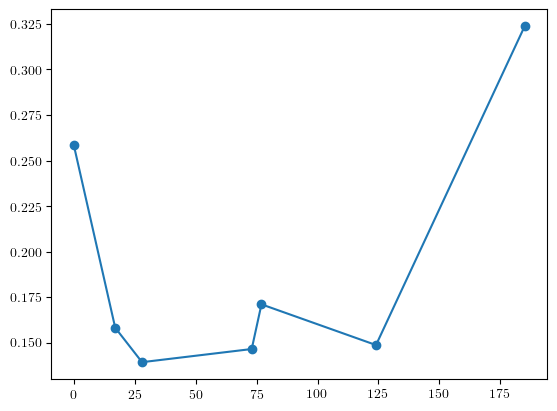

In [775]:
# plt.boxplot(fit_total)
plt.plot(dominant_list, fit_total, marker = 'o')
plt.show()

In [510]:
relative_fitness = (r[dominant_list] + np.sum(A[dominant_list], axis = 1))[0]/(r[dominant_list] + np.sum(A[dominant_list], axis = 1))

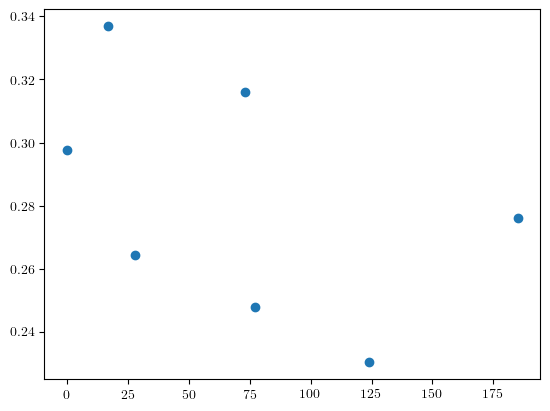

In [634]:
plt.scatter(dominant_list, r[dominant_list])
plt.show()

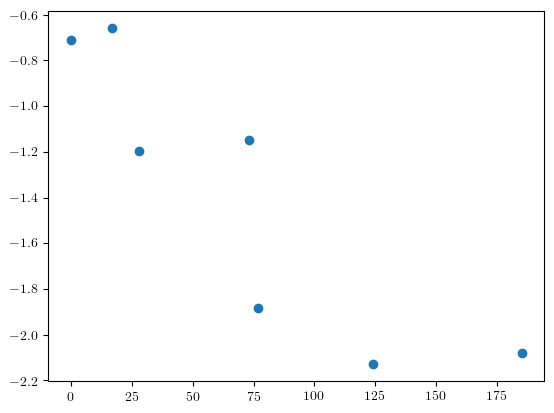

In [526]:
plt.scatter(dominant_list, fitness)
plt.show()

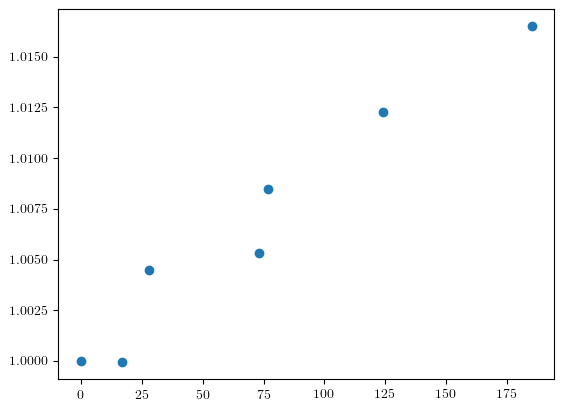

In [513]:
plt.scatter(dominant_list, relative_fitness)
# plt.yscale('log')
# plt.xscale('log')
plt.show()

Link to data: [https://github.com/hodcroftlab/covariants/data/perCountryData.json](https://github.com/hodcroftlab/covariants/blob/master/web/data/perCountryData.json)

In [725]:
f = open('covariants_data_country.json')
data = json.load(f)

In [726]:
np.array(list(data['regions'][0]['distributions'][8]['distribution'][0]['cluster_counts'].keys()))

array(['20A.EU2', '20A/S:98F', '20B/S:732A', '20E (EU1)',
       '20H (Beta, V2)', '20I (Alpha, V1)', '20J (Gamma, V3)',
       '21A (Delta)', '21D (Eta)', '21G (Lambda)', '21H (Mu)',
       '21I (Delta)', '21J (Delta)', '21K (Omicron)', '21L (Omicron)',
       '22A (Omicron)', '22B (Omicron)', '22C (Omicron)', '22D (Omicron)',
       '22E (Omicron)', '22F (Omicron)', '23A (Omicron)', 'S:677H.Robin1',
       'recombinant'], dtype='<U15')

In [727]:
data_covariants = {}
data_covariants['Week'] = []
data_covariants['Total_samples'] = []
for i in range(len(data['regions'][0]['distributions'][8]['distribution'][0]['cluster_counts'])):
    name = list(data['regions'][0]['distributions'][8]['distribution'][0]['cluster_counts'].keys())[i]
    data_covariants[name] = []

for i in range(len(data['regions'][0]['distributions'][8]['distribution'])):
    data_covariants['Week'].append(data['regions'][0]['distributions'][8]['distribution'][i]['week'])
    data_covariants['Total_samples'].append(data['regions'][0]['distributions'][8]['distribution'][i]['total_sequences'])
    for j in range(len(data['regions'][0]['distributions'][8]['distribution'][i]['cluster_counts'])):
        name = list(data['regions'][0]['distributions'][8]['distribution'][i]['cluster_counts'].keys())[j]
        data_covariants[name].append(data['regions'][0]['distributions'][8]['distribution'][i]['cluster_counts'][name])

In [728]:
df_covariants = pd.DataFrame(data_covariants)

In [730]:
df_covariants = df_covariants.drop(columns=['20A.EU2', '20A/S:98F', '20B/S:732A', '20E (EU1)',
                                            'S:677H.Robin1', '21D (Eta)', '21G (Lambda)', '21H (Mu)',
                                           '22D (Omicron)', '21A (Delta)', '21I (Delta)', 'recombinant'])

In [731]:
df_covariants.head()

,Week,Total_samples,"20H (Beta, V2)","20I (Alpha, V1)","20J (Gamma, V3)",21J (Delta),21K (Omicron),21L (Omicron),22A (Omicron),22B (Omicron),22C (Omicron),22E (Omicron),22F (Omicron),23A (Omicron)
0,2020-04-27,305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-05-11,198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-05-25,292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-06-08,344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-06-22,458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [732]:
max(100*df_covariants['22C (Omicron)']/df_covariants['Total_samples'])

3.6363636363636362

In [733]:
df_covariants['Week'] = pd.to_datetime(df_covariants['Week'], format = '%Y-%m-%d')

In [734]:
(np.array(df_covariants[df_covariants.columns[1:]]) == 0).all()

False

In [735]:
labels = ['Beta (B.1.351)','Alpha (B.1.1.7)','Gamma (P.1)','Delta (B.1.617.2)','Omicron (BA.1)',
         'Omicron (BA.2)', 'Omicron (BA.4)', 'Omicron (BA.5)', 'Omicron (BA.2.12.1)',
          'Omicron (BQ.1)', 'Omicron (XBB)', 'Omicron (XBB.1.5)']

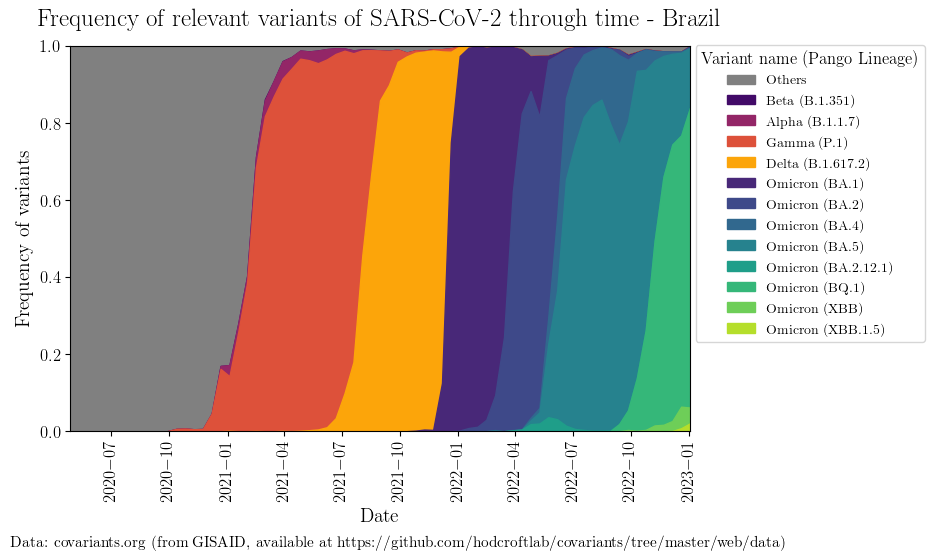

In [741]:
fig, ax = plt.subplots(figsize=(8,5))

plt.fill_between(df_covariants['Week'], 0,
                1, label = 'Others', color = 'grey')
for i in range(len(df_covariants.columns[2:])):
    if i < 4:
        plt.fill_between(df_covariants['Week'], 0,
                         np.sum(df_covariants[df_covariants.columns[2+i:]], axis = 1)/df_covariants['Total_samples'],
                         label = labels[i],
                         color = sns.color_palette('inferno', 4)[i])
    else:
        plt.fill_between(df_covariants['Week'], 0,
                         np.sum(df_covariants[df_covariants.columns[2+i:]], axis = 1)/df_covariants['Total_samples'],
                         label = labels[i],
                         color = sns.color_palette('viridis', 8)[i-4])

lgd = plt.legend(title = 'Variant name (Pango Lineage)', bbox_to_anchor = (1.39, 1.02))
title = lgd.get_title()
title.set_fontsize(12)
plt.xlim(df_covariants['Week'][0], df_covariants['Week'][len(df_covariants['Week'])-1])
plt.ylim(0, 1)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Frequency of variants', fontsize = 14)
plt.xticks(fontsize = 12, rotation = 90)
plt.yticks(fontsize = 12)
plt.title('Frequency of relevant variants of SARS-CoV-2 through time - Brazil', fontsize = 18, pad = 14)
fig.text(0.05, -0.12, 'Data: covariants.org (from GISAID, available at https://github.com/hodcroftlab/covariants/tree/master/web/data)',
         fontsize = 11)
plt.savefig('Plots/SARS-CoV-2_variants_frequency_different_cmap_omicron.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()